<a href="https://colab.research.google.com/github/chanho-275/WOWS/blob/main/Dynamic_Delta_Hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

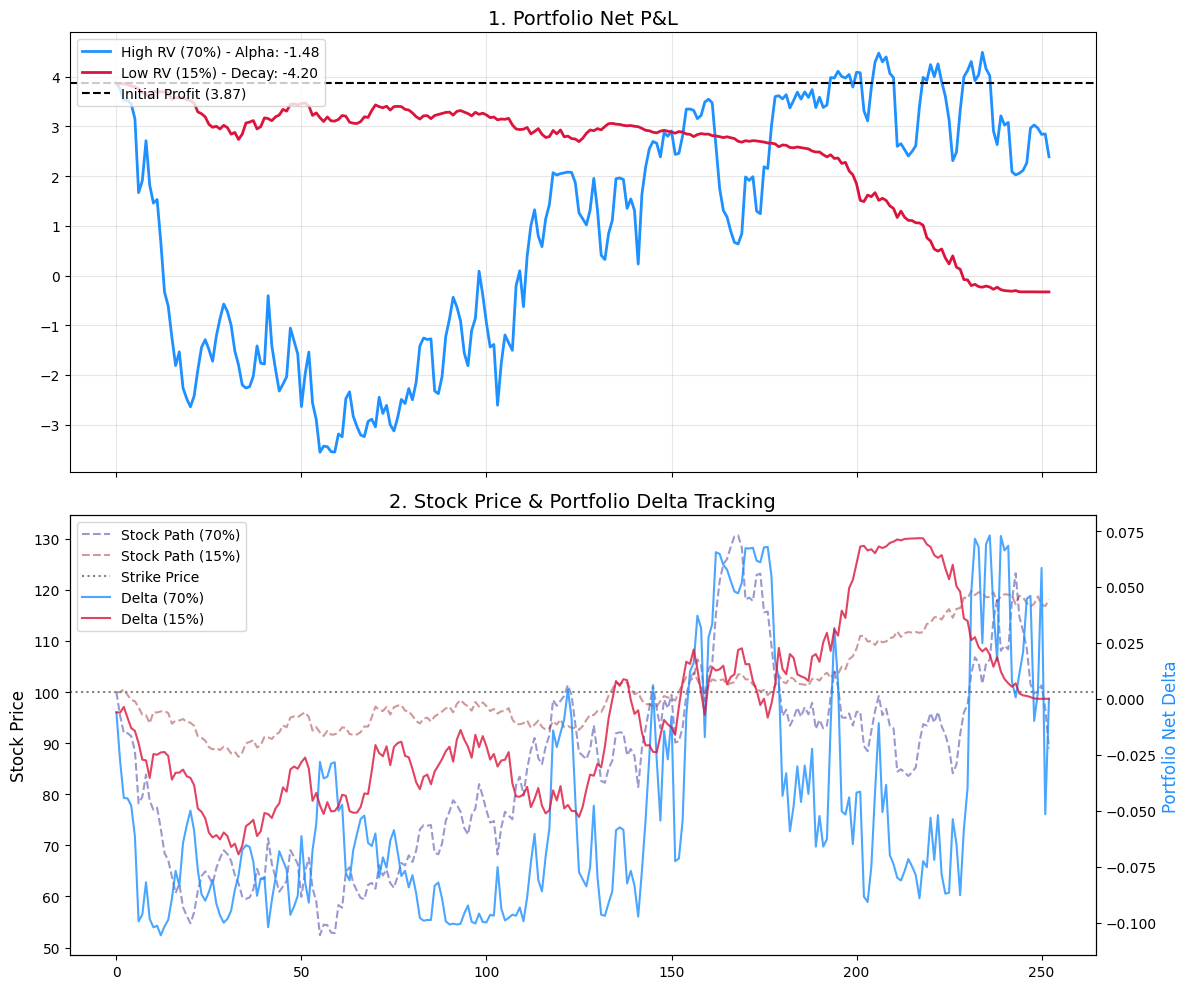

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. BS 함수 동일]
def get_bs_info(S, K, T, r, sigma):
    if T <= 1e-5:
        return max(S - K, 0), (1.0 if S > K else 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

# [2. 환경 설정 동일]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days, dt = 252, 1/252

# [3. 초기 수익 계산 동일]
p_low_init, d_low_init = get_bs_info(S0, K, T_total, r, iv_low)
p_high_init, d_high_init = get_bs_info(S0, K, T_total, r, iv_high)
fixed_profit = p_high_init - p_low_init

# [4. 시뮬레이션 함수 (델타 기록 추가)]
def run_integrated_sim(rv_value):
    S = S0
    trading_pnl_acc = 0
    pnl_history = [fixed_profit]
    stock_path = [S0]
    delta_history = [(d_low_init - d_high_init)] # 델타 기록 추가

    current_delta = d_low_init - d_high_init
    hedge_ratio = -current_delta

    for i in range(1, days + 1):
        curr_T = T_total - (i * dt)
        dS = S * ((r - 0.5 * rv_value**2) * dt + rv_value * np.sqrt(dt) * np.random.normal())

        trading_pnl_acc += hedge_ratio * dS
        S += dS
        stock_path.append(S)

        _, d_l = get_bs_info(S, K, curr_T, r, iv_low)
        _, d_h = get_bs_info(S, K, curr_T, r, iv_high)

        current_delta = d_l - d_h
        delta_history.append(current_delta) # 델타 저장
        hedge_ratio = -current_delta

        p_l, _ = get_bs_info(S, K, curr_T, r, iv_low)
        p_h, _ = get_bs_info(S, K, curr_T, r, iv_high)
        total_pnl = (p_h - p_l) + trading_pnl_acc
        pnl_history.append(total_pnl)

    return pnl_history, stock_path, delta_history

# [5. 실행]
pnl_win, stock_win, delta_win = run_integrated_sim(0.70)
pnl_lose, stock_lose, delta_lose = run_integrated_sim(0.15)

# [6. 결과 시각화]
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 첫 번째: P&L
axes[0].plot(pnl_win, label=f'High RV (70%) - Alpha: {pnl_win[-1]-fixed_profit:.2f}', color='dodgerblue', lw=2)
axes[0].plot(pnl_lose, label=f'Low RV (15%) - Decay: {pnl_lose[-1]-fixed_profit:.2f}', color='crimson', lw=2)
axes[0].axhline(fixed_profit, color='black', ls='--', label=f'Initial Profit ({fixed_profit:.2f})')
axes[0].set_title("1. Portfolio Net P&L", fontsize=14)
axes[0].legend(loc='upper left'); axes[0].grid(True, alpha=0.3)

# 두 번째: 주가 경로 및 델타 (TwinX 사용)
ax2_stock = axes[1]
ax2_delta = axes[1].twinx() # 오른쪽 Y축 생성

# 주가 그래프 (기존 유지)
ax2_stock.plot(stock_win, color='darkblue', ls='--', alpha=0.4, label='Stock Path (70%)')
ax2_stock.plot(stock_lose, color='darkred', ls='--', alpha=0.4, label='Stock Path (15%)')
ax2_stock.axhline(K, color='gray', ls=':', label='Strike Price')
ax2_stock.set_ylabel("Stock Price", fontsize=12)
ax2_stock.set_title("2. Stock Price & Portfolio Delta Tracking", fontsize=14)

# 델타 그래프 (추가)
ax2_delta.plot(delta_win, color='dodgerblue', alpha=0.8, label='Delta (70%)')
ax2_delta.plot(delta_lose, color='crimson', alpha=0.8, label='Delta (15%)')
ax2_delta.set_ylabel("Portfolio Net Delta", fontsize=12, color='dodgerblue')

# 범례 합치기
lines1, labels1 = ax2_stock.get_legend_handles_labels()
lines2, labels2 = ax2_delta.get_legend_handles_labels()
ax2_stock.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

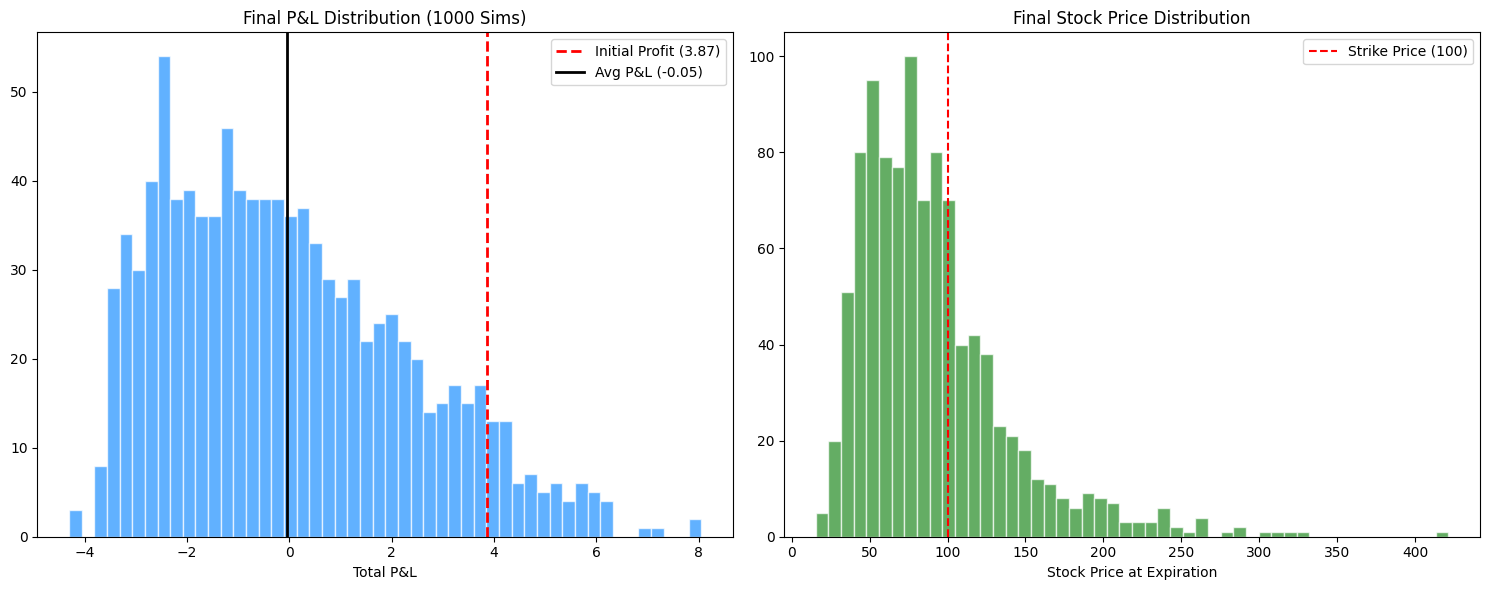

평균 수익: -0.0479
수익 발생 확률: 43.90%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. BS 함수 (동일)]
def get_bs_info(S, K, T, r, sigma):
    if T <= 1e-5: return max(S - K, 0), (1.0 if S > K else 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d1 - sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return price, delta

# [2. 환경 설정]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days, dt = 252, 1/252
n_simulations = 1000  # 1,000번 시뮬레이션
rv_value = 0.50       # 실현 변동성 50% 가정 (BEV보다 높은 상태)

# 초기 확정 이익
p_l_i, _ = get_bs_info(S0, K, T_total, r, iv_low)
p_h_i, _ = get_bs_info(S0, K, T_total, r, iv_high)
fixed_profit = p_h_i - p_l_i

final_pnls = []
final_stock_prices = []

# [3. 반복 시뮬레이션 시작]
for sim in range(n_simulations):
    S = S0
    trading_pnl_acc = 0
    _, d_l = get_bs_info(S, K, T_total, r, iv_low)
    _, d_h = get_bs_info(S, K, T_total, r, iv_high)
    hedge_ratio = -(d_l - d_h)

    for i in range(1, days + 1):
        curr_T = T_total - (i * dt)
        dS = S * ((r - 0.5 * rv_value**2) * dt + rv_value * np.sqrt(dt) * np.random.normal())
        trading_pnl_acc += hedge_ratio * dS
        S += dS

        _, d_l = get_bs_info(S, K, curr_T, r, iv_low)
        _, d_h = get_bs_info(S, K, curr_T, r, iv_high)
        hedge_ratio = -(d_l - d_h)

    p_l_end, _ = get_bs_info(S, K, 0, r, iv_low)
    p_h_end, _ = get_bs_info(S, K, 0, r, iv_high)

    total_pnl = (p_h_end - p_l_end) + trading_pnl_acc
    final_pnls.append(total_pnl)
    final_stock_prices.append(S)

# [4. 시각화]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 히스토그램: 최종 손익 분포
ax1.hist(final_pnls, bins=50, color='dodgerblue', edgecolor='white', alpha=0.7)
ax1.axvline(fixed_profit, color='red', ls='--', lw=2, label=f'Initial Profit ({fixed_profit:.2f})')
ax1.axvline(np.mean(final_pnls), color='black', ls='-', lw=2, label=f'Avg P&L ({np.mean(final_pnls):.2f})')
ax1.set_title(f"Final P&L Distribution ({n_simulations} Sims)")
ax1.set_xlabel("Total P&L"); ax1.legend()

# 히스토그램: 만기 주가 분포
ax2.hist(final_stock_prices, bins=50, color='forestgreen', edgecolor='white', alpha=0.7)
ax2.axvline(K, color='red', ls='--', label=f'Strike Price ({K})')
ax2.set_title("Final Stock Price Distribution")
ax2.set_xlabel("Stock Price at Expiration"); ax2.legend()

plt.tight_layout()
plt.show()

print(f"평균 수익: {np.mean(final_pnls):.4f}")
print(f"수익 발생 확률: {(np.array(final_pnls) > 0).sum() / n_simulations * 100:.2f}%")

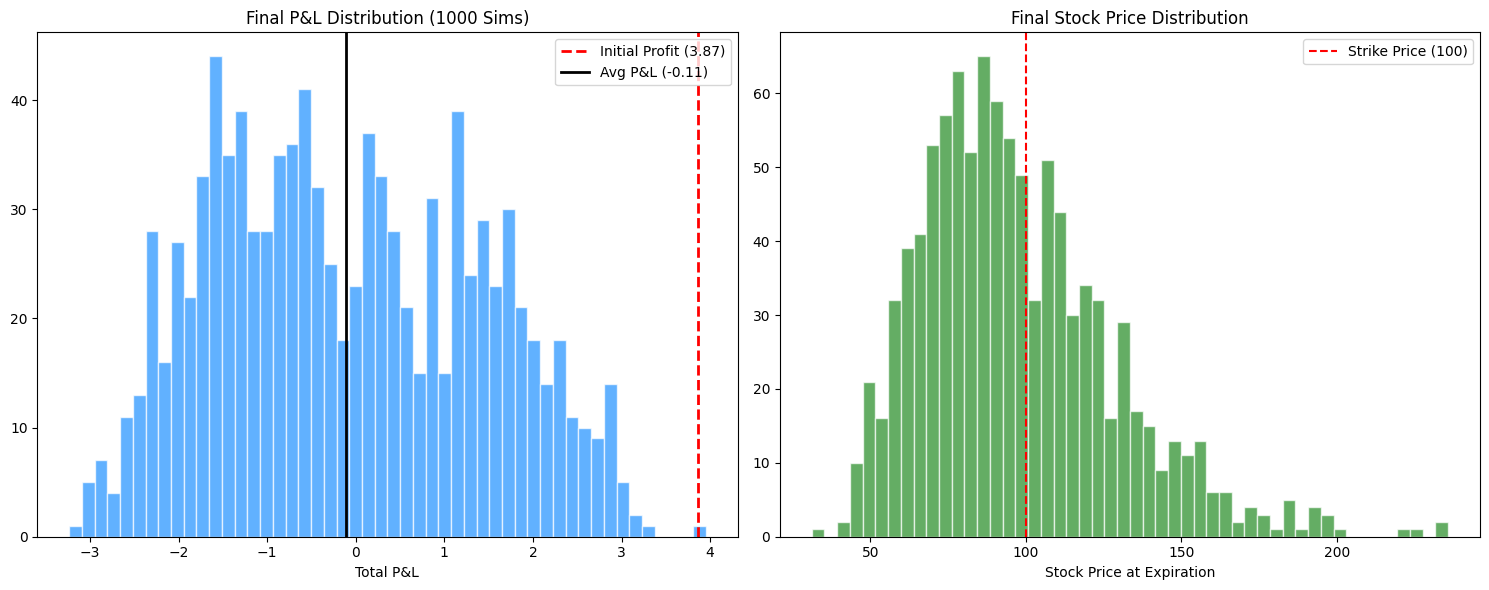

평균 수익: -0.1077
수익 발생 확률: 45.60%


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. BS 함수 (동일)]
def get_bs_info(S, K, T, r, sigma):
    if T <= 1e-5: return max(S - K, 0), (1.0 if S > K else 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d1 - sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return price, delta

# [2. 환경 설정]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days, dt = 252, 1/252
n_simulations = 1000  # 1,000번 시뮬레이션
rv_value = 0.30       # 실현 변동성 30% 가정

# 초기 확정 이익
p_l_i, _ = get_bs_info(S0, K, T_total, r, iv_low)
p_h_i, _ = get_bs_info(S0, K, T_total, r, iv_high)
fixed_profit = p_h_i - p_l_i

final_pnls = []
final_stock_prices = []

# [3. 반복 시뮬레이션 시작]
for sim in range(n_simulations):
    S = S0
    trading_pnl_acc = 0
    _, d_l = get_bs_info(S, K, T_total, r, iv_low)
    _, d_h = get_bs_info(S, K, T_total, r, iv_high)
    hedge_ratio = -(d_l - d_h)

    for i in range(1, days + 1):
        curr_T = T_total - (i * dt)
        dS = S * ((r - 0.5 * rv_value**2) * dt + rv_value * np.sqrt(dt) * np.random.normal())
        trading_pnl_acc += hedge_ratio * dS
        S += dS

        _, d_l = get_bs_info(S, K, curr_T, r, iv_low)
        _, d_h = get_bs_info(S, K, curr_T, r, iv_high)
        hedge_ratio = -(d_l - d_h)

    p_l_end, _ = get_bs_info(S, K, 0, r, iv_low)
    p_h_end, _ = get_bs_info(S, K, 0, r, iv_high)

    total_pnl = (p_h_end - p_l_end) + trading_pnl_acc
    final_pnls.append(total_pnl)
    final_stock_prices.append(S)

# [4. 시각화]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 히스토그램: 최종 손익 분포
ax1.hist(final_pnls, bins=50, color='dodgerblue', edgecolor='white', alpha=0.7)
ax1.axvline(fixed_profit, color='red', ls='--', lw=2, label=f'Initial Profit ({fixed_profit:.2f})')
ax1.axvline(np.mean(final_pnls), color='black', ls='-', lw=2, label=f'Avg P&L ({np.mean(final_pnls):.2f})')
ax1.set_title(f"Final P&L Distribution ({n_simulations} Sims)")
ax1.set_xlabel("Total P&L"); ax1.legend()

# 히스토그램: 만기 주가 분포
ax2.hist(final_stock_prices, bins=50, color='forestgreen', edgecolor='white', alpha=0.7)
ax2.axvline(K, color='red', ls='--', label=f'Strike Price ({K})')
ax2.set_title("Final Stock Price Distribution")
ax2.set_xlabel("Stock Price at Expiration"); ax2.legend()

plt.tight_layout()
plt.show()

print(f"평균 수익: {np.mean(final_pnls):.4f}")
print(f"수익 발생 확률: {(np.array(final_pnls) > 0).sum() / n_simulations * 100:.2f}%")

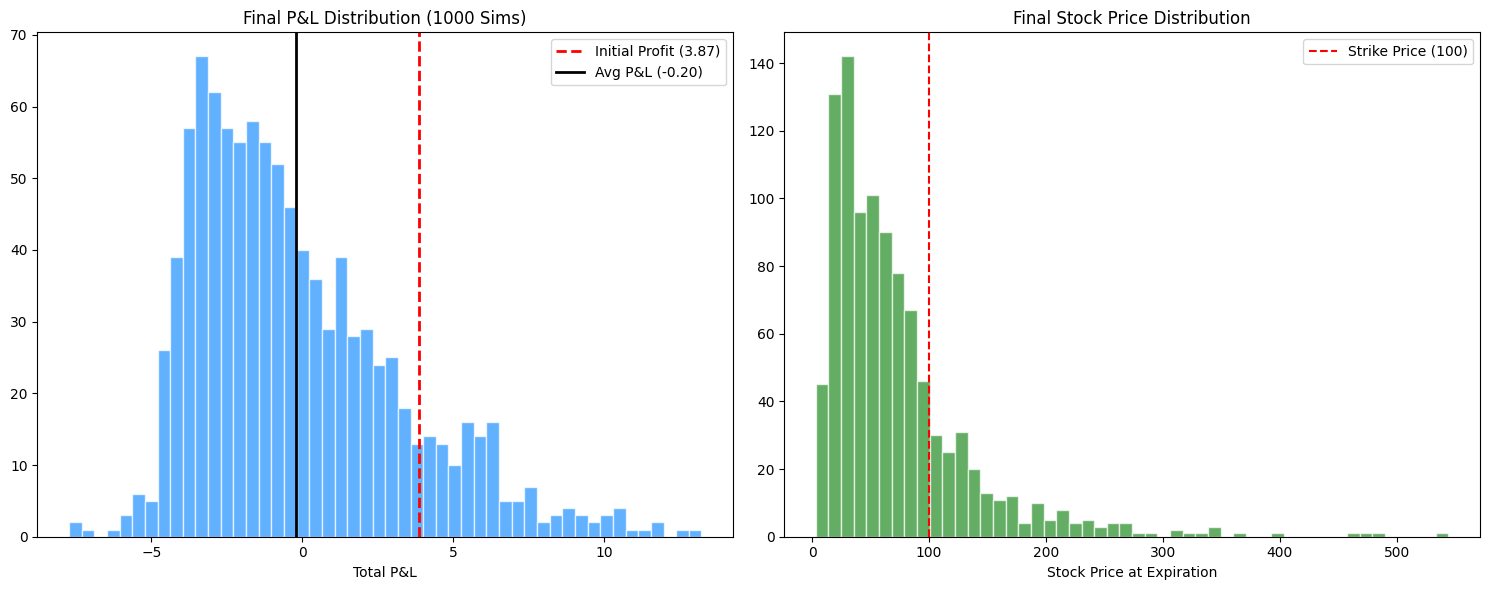

평균 수익: -0.2035
수익 발생 확률: 38.80%


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. BS 함수 (동일)]
def get_bs_info(S, K, T, r, sigma):
    if T <= 1e-5: return max(S - K, 0), (1.0 if S > K else 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d1 - sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return price, delta

# [2. 환경 설정]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days, dt = 252, 1/252
n_simulations = 1000  # 1,000번 시뮬레이션
rv_value = 0.8       # 실현 변동성 80% 가정

# 초기 확정 이익
p_l_i, _ = get_bs_info(S0, K, T_total, r, iv_low)
p_h_i, _ = get_bs_info(S0, K, T_total, r, iv_high)
fixed_profit = p_h_i - p_l_i

final_pnls = []
final_stock_prices = []

# [3. 반복 시뮬레이션 시작]
for sim in range(n_simulations):
    S = S0
    trading_pnl_acc = 0
    _, d_l = get_bs_info(S, K, T_total, r, iv_low)
    _, d_h = get_bs_info(S, K, T_total, r, iv_high)
    hedge_ratio = -(d_l - d_h)

    for i in range(1, days + 1):
        curr_T = T_total - (i * dt)
        dS = S * ((r - 0.5 * rv_value**2) * dt + rv_value * np.sqrt(dt) * np.random.normal())
        trading_pnl_acc += hedge_ratio * dS
        S += dS

        _, d_l = get_bs_info(S, K, curr_T, r, iv_low)
        _, d_h = get_bs_info(S, K, curr_T, r, iv_high)
        hedge_ratio = -(d_l - d_h)

    p_l_end, _ = get_bs_info(S, K, 0, r, iv_low)
    p_h_end, _ = get_bs_info(S, K, 0, r, iv_high)

    total_pnl = (p_h_end - p_l_end) + trading_pnl_acc
    final_pnls.append(total_pnl)
    final_stock_prices.append(S)

# [4. 시각화]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 히스토그램: 최종 손익 분포
ax1.hist(final_pnls, bins=50, color='dodgerblue', edgecolor='white', alpha=0.7)
ax1.axvline(fixed_profit, color='red', ls='--', lw=2, label=f'Initial Profit ({fixed_profit:.2f})')
ax1.axvline(np.mean(final_pnls), color='black', ls='-', lw=2, label=f'Avg P&L ({np.mean(final_pnls):.2f})')
ax1.set_title(f"Final P&L Distribution ({n_simulations} Sims)")
ax1.set_xlabel("Total P&L"); ax1.legend()

# 히스토그램: 만기 주가 분포
ax2.hist(final_stock_prices, bins=50, color='forestgreen', edgecolor='white', alpha=0.7)
ax2.axvline(K, color='red', ls='--', label=f'Strike Price ({K})')
ax2.set_title("Final Stock Price Distribution")
ax2.set_xlabel("Stock Price at Expiration"); ax2.legend()

plt.tight_layout()
plt.show()

print(f"평균 수익: {np.mean(final_pnls):.4f}")
print(f"수익 발생 확률: {(np.array(final_pnls) > 0).sum() / n_simulations * 100:.2f}%")

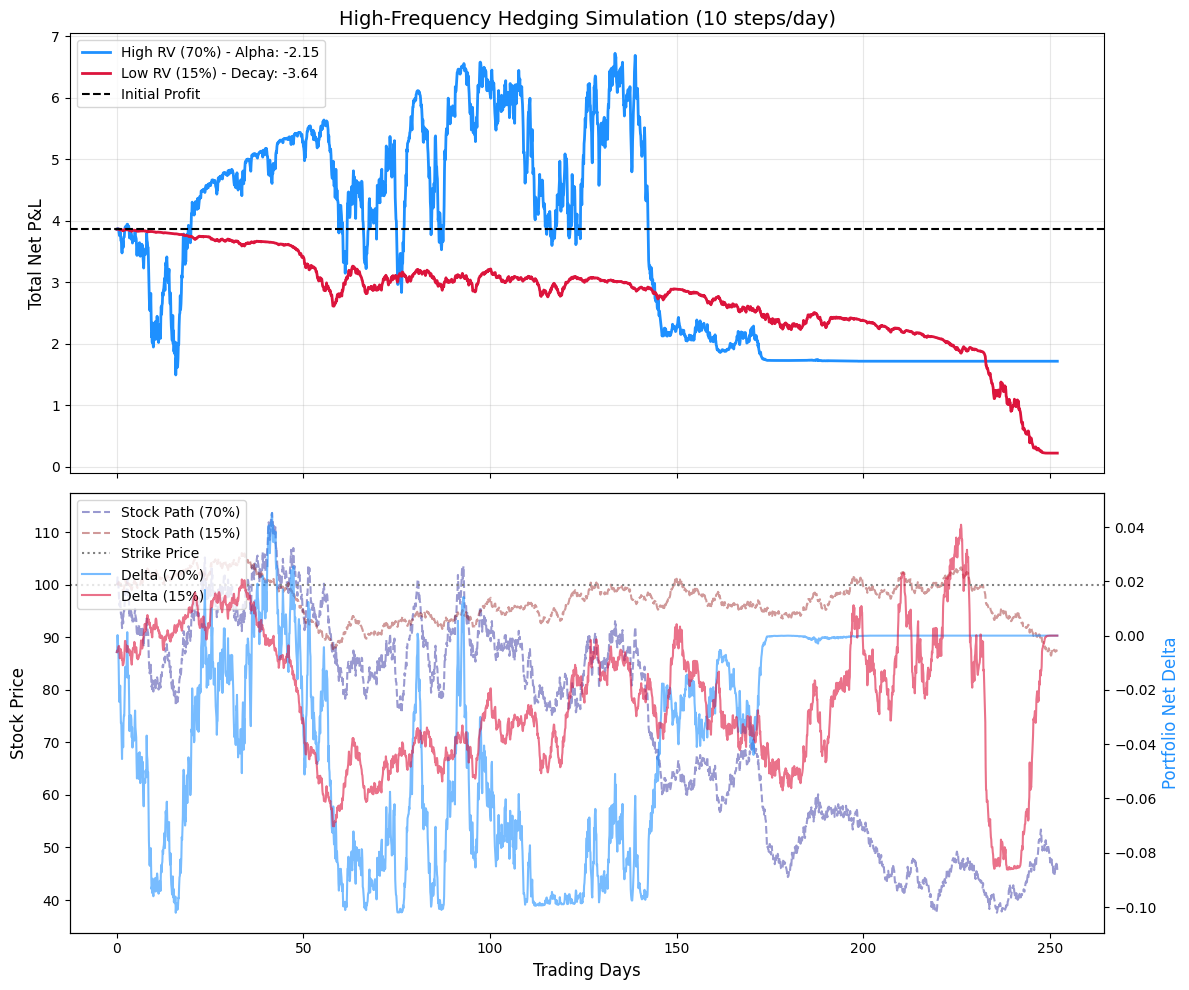

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. 블랙-숄즈 가격 및 델타 계산 함수]
def get_bs_info(S, K, T, r, sigma):
    if T <= 1e-6: # 만기 시점 보정
        return max(S - K, 0), (1.0 if S > K else 0.0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)

    return price, delta

# [2. 환경 설정: 하루를 10번 쪼개도록 변경]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days = 252
steps_per_day = 10              # 하루에 헤징을 10번 수행 (수정된 부분)
total_steps = days * steps_per_day
dt = 1 / total_steps            # 시간 간격이 1/252에서 1/2520으로 미세해짐

# [3. 초기 확정 수익 계산]
p_low_init, d_low_init = get_bs_info(S0, K, T_total, r, iv_low)
p_high_init, d_high_init = get_bs_info(S0, K, T_total, r, iv_high)
fixed_profit = p_high_init - p_low_init

# [4. 정교해진 시뮬레이션 함수]
def run_high_freq_sim(rv_value):
    S = S0
    trading_pnl_acc = 0
    pnl_history = [fixed_profit]
    stock_path = [S0]
    delta_history = [(d_low_init - d_high_init)]

    # 초기 헤지 비율
    current_delta = d_low_init - d_high_init
    hedge_ratio = -current_delta

    for i in range(1, total_steps + 1):
        curr_T = max(0, T_total - (i * dt))

        # 더 세밀해진 주가 이동 (dt가 작아져서 변동 폭이 부드러워짐)
        dS = S * ((r - 0.5 * rv_value**2) * dt + rv_value * np.sqrt(dt) * np.random.normal())

        trading_pnl_acc += hedge_ratio * dS
        S += dS
        stock_path.append(S)

        # 새로운 헤지 비율 갱신 (더 잦은 리밸런싱)
        _, d_l = get_bs_info(S, K, curr_T, r, iv_low)
        _, d_h = get_bs_info(S, K, curr_T, r, iv_high)

        current_delta = d_l - d_h
        delta_history.append(current_delta)
        hedge_ratio = -current_delta

        # MTM 평가
        p_l, _ = get_bs_info(S, K, curr_T, r, iv_low)
        p_h, _ = get_bs_info(S, K, curr_T, r, iv_high)
        total_pnl = (p_h - p_l) + trading_pnl_acc
        pnl_history.append(total_pnl)

    return pnl_history, stock_path, delta_history

# [5. 실행 (고변동성 70%, 저변동성 15%)]
pnl_win, stock_win, delta_win = run_high_freq_sim(0.70)
pnl_lose, stock_lose, delta_lose = run_high_freq_sim(0.15)

# [6. 결과 시각화]
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 첫 번째: P&L (X축 단위를 Day로 변환하여 시각화)
x_axis = np.linspace(0, days, len(pnl_win))
axes[0].plot(x_axis, pnl_win, label=f'High RV (70%) - Alpha: {pnl_win[-1]-fixed_profit:.2f}', color='dodgerblue', lw=2)
axes[0].plot(x_axis, pnl_lose, label=f'Low RV (15%) - Decay: {pnl_lose[-1]-fixed_profit:.2f}', color='crimson', lw=2)
axes[0].axhline(fixed_profit, color='black', ls='--', label='Initial Profit')
axes[0].set_title(f"High-Frequency Hedging Simulation ({steps_per_day} steps/day)", fontsize=14)
axes[0].set_ylabel("Total Net P&L", fontsize=12)
axes[0].legend(loc='upper left'); axes[0].grid(True, alpha=0.3)

# 두 번째: 주가 및 델타 추적
ax2_stock = axes[1]
ax2_delta = axes[1].twinx()

ax2_stock.plot(x_axis, stock_win, color='darkblue', ls='--', alpha=0.4, label='Stock Path (70%)')
ax2_stock.plot(x_axis, stock_lose, color='darkred', ls='--', alpha=0.4, label='Stock Path (15%)')
ax2_stock.axhline(K, color='gray', ls=':', label='Strike Price')
ax2_stock.set_ylabel("Stock Price", fontsize=12)
ax2_stock.set_xlabel("Trading Days", fontsize=12)

ax2_delta.plot(x_axis, delta_win, color='dodgerblue', alpha=0.6, label='Delta (70%)')
ax2_delta.plot(x_axis, delta_lose, color='crimson', alpha=0.6, label='Delta (15%)')
ax2_delta.set_ylabel("Portfolio Net Delta", fontsize=12, color='dodgerblue')

lines1, labels1 = ax2_stock.get_legend_handles_labels()
lines2, labels2 = ax2_delta.get_legend_handles_labels()
ax2_stock.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

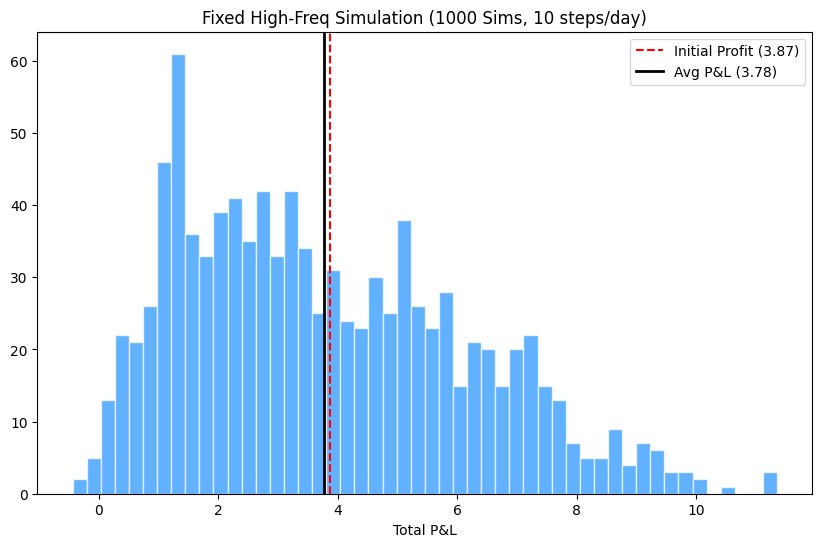

평균 수익: 3.7757
확정 수익 돌파 확률: 43.30%


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. 벡터화된 BS 델타 함수 - 에러 수정본]
def get_bs_delta_vec(S, K, T, r, sigma):
    # T가 스칼라(숫자 하나)일 경우를 위해 처리
    delta = np.zeros_like(S)

    if T <= 1e-6:
        delta = np.where(S > K, 1.0, 0.0)
        return delta

    # 벡터 연산 수행
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# [2. 환경 설정]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days, steps_per_day = 252, 10
total_steps = days * steps_per_day
dt = 1 / total_steps
n_sims = 1000
rv = 0.50

# 초기 확정 수익 계산
d1_l = (np.log(S0/K) + (r + 0.5*iv_low**2)*T_total) / (iv_low*np.sqrt(T_total))
d1_h = (np.log(S0/K) + (r + 0.5*iv_high**2)*T_total) / (iv_high*np.sqrt(T_total))
p_l_init = S0*norm.cdf(d1_l) - K*np.exp(-r*T_total)*norm.cdf(d1_l - iv_low*np.sqrt(T_total))
p_h_init = S0*norm.cdf(d1_h) - K*np.exp(-r*T_total)*norm.cdf(d1_h - iv_high*np.sqrt(T_total))
fixed_profit = p_h_init - p_l_init

# [3. 주가 경로 생성]
rand_returns = np.random.normal((r - 0.5 * rv**2) * dt, rv * np.sqrt(dt), (total_steps, n_sims))
price_paths = S0 * np.exp(np.cumsum(rand_returns, axis=0))
price_paths = np.vstack([np.full(n_sims, S0), price_paths])

# [4. 동적 헤징 루프]
trading_pnl_acc = np.zeros(n_sims)

for i in range(total_steps):
    curr_T = max(0, T_total - i * dt)
    S_curr = price_paths[i]

    # 수정된 델타 계산 (S_curr는 1000개 배열, curr_T는 숫자 하나)
    d_l = get_bs_delta_vec(S_curr, K, curr_T, r, iv_low)
    d_h = get_bs_delta_vec(S_curr, K, curr_T, r, iv_high)
    hedge_ratio = -(d_l - d_h)

    dS = price_paths[i+1] - S_curr
    trading_pnl_acc += hedge_ratio * dS

# [5. 최종 결과]
final_pnls = trading_pnl_acc + fixed_profit

# [6. 시각화]
plt.figure(figsize=(10, 6))
plt.hist(final_pnls, bins=50, color='dodgerblue', edgecolor='white', alpha=0.7)
plt.axvline(fixed_profit, color='red', ls='--', label=f'Initial Profit ({fixed_profit:.2f})')
plt.axvline(np.mean(final_pnls), color='black', lw=2, label=f'Avg P&L ({np.mean(final_pnls):.2f})')
plt.title(f"Fixed High-Freq Simulation (1000 Sims, 10 steps/day)")
plt.xlabel("Total P&L")
plt.legend()
plt.show()

print(f"평균 수익: {np.mean(final_pnls):.4f}")
print(f"확정 수익 돌파 확률: {(final_pnls > fixed_profit).mean() * 100:.2f}%")

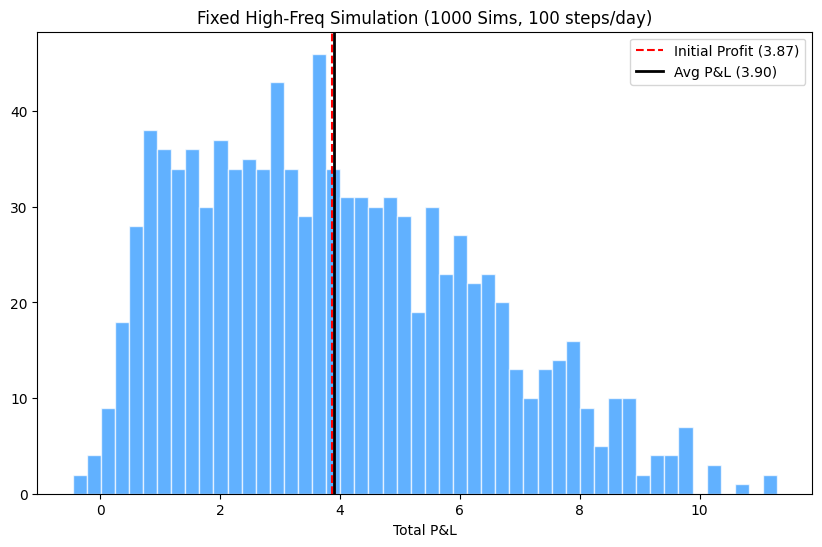

평균 수익: 3.8992
확정 수익 돌파 확률: 46.10%


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. 벡터화된 BS 델타 함수 - 에러 수정본]
def get_bs_delta_vec(S, K, T, r, sigma):
    # T가 스칼라(숫자 하나)일 경우를 위해 처리
    delta = np.zeros_like(S)

    if T <= 1e-6:
        delta = np.where(S > K, 1.0, 0.0)
        return delta

    # 벡터 연산 수행
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# [2. 환경 설정]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days, steps_per_day = 252, 100
total_steps = days * steps_per_day
dt = 1 / total_steps
n_sims = 1000
rv = 0.50

# 초기 확정 수익 계산
d1_l = (np.log(S0/K) + (r + 0.5*iv_low**2)*T_total) / (iv_low*np.sqrt(T_total))
d1_h = (np.log(S0/K) + (r + 0.5*iv_high**2)*T_total) / (iv_high*np.sqrt(T_total))
p_l_init = S0*norm.cdf(d1_l) - K*np.exp(-r*T_total)*norm.cdf(d1_l - iv_low*np.sqrt(T_total))
p_h_init = S0*norm.cdf(d1_h) - K*np.exp(-r*T_total)*norm.cdf(d1_h - iv_high*np.sqrt(T_total))
fixed_profit = p_h_init - p_l_init

# [3. 주가 경로 생성]
rand_returns = np.random.normal((r - 0.5 * rv**2) * dt, rv * np.sqrt(dt), (total_steps, n_sims))
price_paths = S0 * np.exp(np.cumsum(rand_returns, axis=0))
price_paths = np.vstack([np.full(n_sims, S0), price_paths])

# [4. 동적 헤징 루프]
trading_pnl_acc = np.zeros(n_sims)

for i in range(total_steps):
    curr_T = max(0, T_total - i * dt)
    S_curr = price_paths[i]

    # 수정된 델타 계산 (S_curr는 1000개 배열, curr_T는 숫자 하나)
    d_l = get_bs_delta_vec(S_curr, K, curr_T, r, iv_low)
    d_h = get_bs_delta_vec(S_curr, K, curr_T, r, iv_high)
    hedge_ratio = -(d_l - d_h)

    dS = price_paths[i+1] - S_curr
    trading_pnl_acc += hedge_ratio * dS

# [5. 최종 결과]
final_pnls = trading_pnl_acc + fixed_profit

# [6. 시각화]
plt.figure(figsize=(10, 6))
plt.hist(final_pnls, bins=50, color='dodgerblue', edgecolor='white', alpha=0.7)
plt.axvline(fixed_profit, color='red', ls='--', label=f'Initial Profit ({fixed_profit:.2f})')
plt.axvline(np.mean(final_pnls), color='black', lw=2, label=f'Avg P&L ({np.mean(final_pnls):.2f})')
plt.title(f"Fixed High-Freq Simulation (1000 Sims, 100 steps/day)")
plt.xlabel("Total P&L")
plt.legend()
plt.show()

print(f"평균 수익: {np.mean(final_pnls):.4f}")
print(f"확정 수익 돌파 확률: {(final_pnls > fixed_profit).mean() * 100:.2f}%")

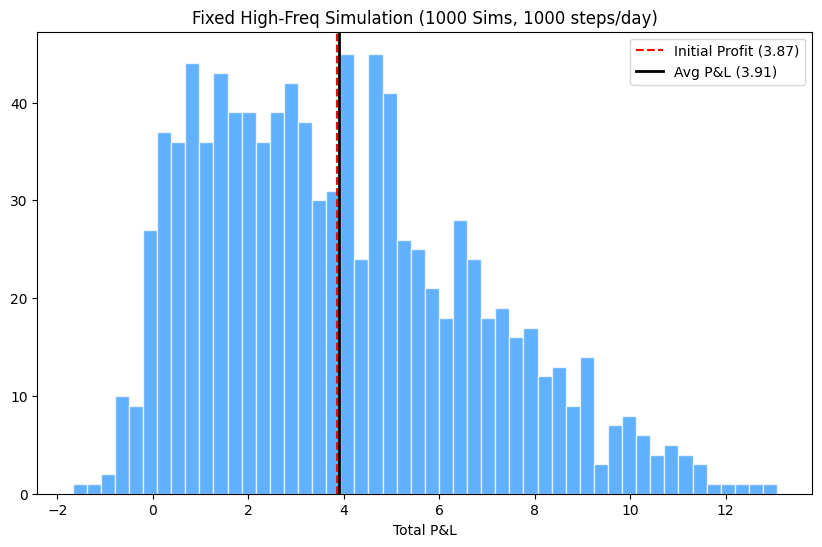

평균 수익: 3.9088
확정 수익 돌파 확률: 46.60%


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. 벡터화된 BS 델타 함수 - 에러 수정본]
def get_bs_delta_vec(S, K, T, r, sigma):
    # T가 스칼라(숫자 하나)일 경우를 위해 처리
    delta = np.zeros_like(S)

    if T <= 1e-6:
        delta = np.where(S > K, 1.0, 0.0)
        return delta

    # 벡터 연산 수행
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# [2. 환경 설정]
S0, K, r, T_total = 100, 100, 0.03, 1.0
iv_low, iv_high = 0.25, 0.35
days, steps_per_day = 252, 1000
total_steps = days * steps_per_day
dt = 1 / total_steps
n_sims = 1000
rv = 0.60

# 초기 확정 수익 계산
d1_l = (np.log(S0/K) + (r + 0.5*iv_low**2)*T_total) / (iv_low*np.sqrt(T_total))
d1_h = (np.log(S0/K) + (r + 0.5*iv_high**2)*T_total) / (iv_high*np.sqrt(T_total))
p_l_init = S0*norm.cdf(d1_l) - K*np.exp(-r*T_total)*norm.cdf(d1_l - iv_low*np.sqrt(T_total))
p_h_init = S0*norm.cdf(d1_h) - K*np.exp(-r*T_total)*norm.cdf(d1_h - iv_high*np.sqrt(T_total))
fixed_profit = p_h_init - p_l_init

# [3. 주가 경로 생성]
rand_returns = np.random.normal((r - 0.5 * rv**2) * dt, rv * np.sqrt(dt), (total_steps, n_sims))
price_paths = S0 * np.exp(np.cumsum(rand_returns, axis=0))
price_paths = np.vstack([np.full(n_sims, S0), price_paths])

# [4. 동적 헤징 루프]
trading_pnl_acc = np.zeros(n_sims)

for i in range(total_steps):
    curr_T = max(0, T_total - i * dt)
    S_curr = price_paths[i]

    # 수정된 델타 계산 (S_curr는 1000개 배열, curr_T는 숫자 하나)
    d_l = get_bs_delta_vec(S_curr, K, curr_T, r, iv_low)
    d_h = get_bs_delta_vec(S_curr, K, curr_T, r, iv_high)
    hedge_ratio = -(d_l - d_h)

    dS = price_paths[i+1] - S_curr
    trading_pnl_acc += hedge_ratio * dS

# [5. 최종 결과]
final_pnls = trading_pnl_acc + fixed_profit

# [6. 시각화]
plt.figure(figsize=(10, 6))
plt.hist(final_pnls, bins=50, color='dodgerblue', edgecolor='white', alpha=0.7)
plt.axvline(fixed_profit, color='red', ls='--', label=f'Initial Profit ({fixed_profit:.2f})')
plt.axvline(np.mean(final_pnls), color='black', lw=2, label=f'Avg P&L ({np.mean(final_pnls):.2f})')
plt.title(f"Fixed High-Freq Simulation (1000 Sims, 1000 steps/day)")
plt.xlabel("Total P&L")
plt.legend()
plt.show()

print(f"평균 수익: {np.mean(final_pnls):.4f}")
print(f"확정 수익 돌파 확률: {(final_pnls > fixed_profit).mean() * 100:.2f}%")

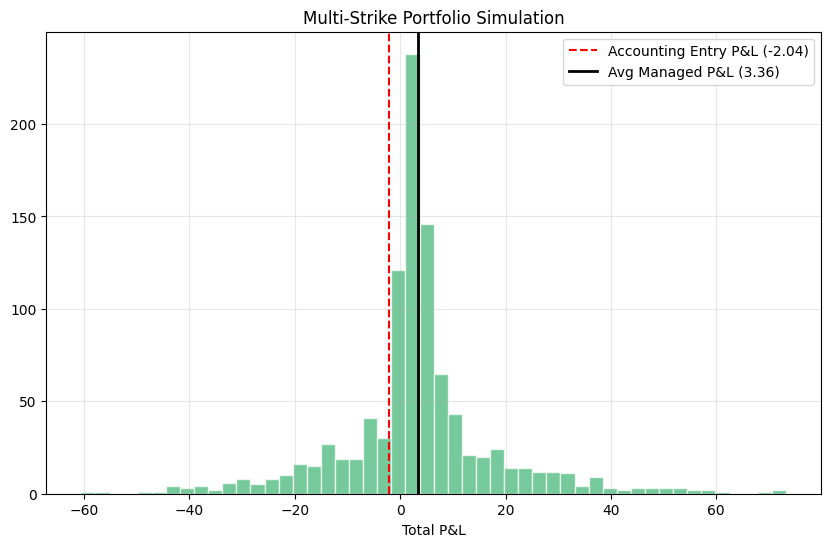

진입 시 회계적 손익: -2.0354
운용 후 최종 평균 손익: 3.3650
확정 수익 돌파 확률: 78.30%


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# [1. 블랙-숄즈 엔진 (스칼라/벡터 겸용)]
def get_bs_info(S, K, T, r, sigma, opt_type):
    # S가 배열인지 확인
    S = np.atleast_1d(S)

    # 만기 시점 혹은 에러 방지용 아주 작은 시간 처리
    if T <= 1e-6:
        if opt_type == 'c':
            price = np.maximum(S - K, 0)
            delta = np.where(S > K, 1.0, 0.0)
        else:
            price = np.maximum(K - S, 0)
            delta = np.where(S < K, -1.0, 0.0)
        return price, delta

    # BS 수식 계산
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if opt_type == 'c':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1

    return price, delta

# [2. 환경 및 포트폴리오 설정]
S0, r = 100, 0.05
days, steps_per_day = 252, 10
total_steps = days * steps_per_day
dt = 1 / total_steps
n_sims = 1000
rv = 0.40 # 실현 변동성 40%

# 주임님이 주신 6개 복합 옵션 리스트
# [타입, 매수(+1)/매도(-1), K, T, r, sigma]
options_list = [
    ['p',  1, 100, 1.0, 0.05, 0.30],
    ['p', -1, 98,  1.0, 0.05, 0.35],
    ['c',  1, 105, 0.5, 0.05, 0.23],
    ['c',  1, 105, 0.5, 0.05, 0.23],
    ['c', -1, 110, 0.5, 0.05, 0.25],
    ['c', -1, 115, 0.5, 0.05, 0.28]
]

# [3. 초기 회계적 이익 계산]
initial_net_cashflow = 0
for opt in options_list:
    p, _ = get_bs_info(S0, opt[2], opt[3], r, opt[5], opt[0])
    initial_net_cashflow -= opt[1] * p[0] # 매도는 현금유입(+), 매수는 유출(-)

# [4. 주가 경로 생성]
rand_returns = np.random.normal((r - 0.5 * rv**2) * dt, rv * np.sqrt(dt), (total_steps, n_sims))
price_paths = S0 * np.exp(np.cumsum(rand_returns, axis=0))
price_paths = np.vstack([np.full(n_sims, S0), price_paths])

# [5. 동적 헤징 루프]
trading_pnl_acc = np.zeros(n_sims)

for i in range(total_steps):
    S_curr = price_paths[i]
    dS = price_paths[i+1] - S_curr
    portfolio_delta = np.zeros(n_sims)

    for opt in options_list:
        curr_T = max(0, opt[3] - i * dt) # 각 옵션별 남은 시간
        _, d = get_bs_info(S_curr, opt[2], curr_T, r, opt[5], opt[0])
        portfolio_delta += opt[1] * d

    hedge_ratio = -portfolio_delta
    trading_pnl_acc += hedge_ratio * dS

# [6. 최종 결과 정산]
final_option_values = np.zeros(n_sims)
S_final = price_paths[-1]
for opt in options_list:
    rem_T = max(0, opt[3] - T_total) # 1년 뒤 시점의 남은 만기
    v_end, _ = get_bs_info(S_final, opt[2], rem_T, r, opt[5], opt[0])
    final_option_values += opt[1] * v_end

total_final_pnls = initial_net_cashflow + final_option_values + trading_pnl_acc

# [7. 시각화]
plt.figure(figsize=(10, 6))
plt.hist(total_final_pnls, bins=50, color='mediumseagreen', edgecolor='white', alpha=0.7)
plt.axvline(initial_net_cashflow, color='red', ls='--', label=f'Accounting Entry P&L ({initial_net_cashflow:.2f})')
plt.axvline(np.mean(total_final_pnls), color='black', lw=2, label=f'Avg Managed P&L ({np.mean(total_final_pnls):.2f})')
plt.title("Multi-Strike Portfolio Simulation")
plt.xlabel("Total P&L"); plt.legend(); plt.grid(alpha=0.3); plt.show()

print(f"진입 시 회계적 손익: {initial_net_cashflow:.4f}")
print(f"운용 후 최종 평균 손익: {np.mean(total_final_pnls):.4f}")
print(f"확정 수익 돌파 확률: {(total_final_pnls > initial_net_cashflow).mean()*100:.2f}%")